In [ ]:
# --- 1. Impor Semua Library yang Dibutuhkan ---
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# --- 2. Memuat Data ---
# Gunakan path lengkap tempat Anda menyimpan file fitur
file_path_features = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\parquet\dataset_final_features_energi_suhu.parquet'

# Baca dataset final ke dalam variabel yang lebih spesifik
df_model_input = pd.read_parquet(file_path_features)

# --- 3. Membersihkan dan Mempersiapkan Data ---
# Hapus baris dengan nilai kosong (NaN) yang muncul akibat pembuatan fitur lag
df_model_input.dropna(inplace=True)
print(f"Jumlah baris data yang siap digunakan setelah dropna: {len(df_model_input)}")

# Definisikan Target dan Fitur
TARGET = 'konsumsi_energi'
FEATURES = [col for col in df_model_input.columns if col not in ['timestamp', TARGET]]

# Ubah tipe data kolom 'meter_id' menjadi kategori agar dipahami LightGBM
df_model_input['meter_id'] = df_model_input['meter_id'].astype('category')

print("\nData siap untuk dibagi menjadi set Latih dan Uji.")
print("Fitur yang akan digunakan:", FEATURES)


Jumlah baris data yang siap digunakan setelah dropna: 331968

Data siap untuk dibagi menjadi set Latih dan Uji.
Fitur yang akan digunakan: ['meter_id', 'is_kelas', 'is_kantor', 'is_penelitian', 'avg_temp_previous_hour', 'jam', 'hari_minggu', 'hari_bulan', 'minggu_tahun', 'bulan', 'tahun', 'apakah_akhir_pekan', 'apakah_jam_kerja', 'konsumsi_lag_1_jam', 'konsumsi_lag_24_jam']


In [3]:
# Pembagian Data (Train-Test Split Berbasis Waktu)

# Tentukan tanggal untuk memisahkan data latih dan uji.
# Contoh: kita gunakan data hingga akhir Maret 2025 untuk latihan, sisanya untuk pengujian.
# Ganti tanggal ini sesuai dengan rentang waktu data Anda.
split_date = '2025-04-01'

# Bagi DataFrame berdasarkan tanggal
train_set = df_model_input[df_model_input['timestamp'] < split_date]
test_set = df_model_input[df_model_input['timestamp'] >= split_date]

# Buat set X (fitur) dan y (target) untuk masing-masing
X_train = train_set[FEATURES]
y_train = train_set[TARGET]

X_test = test_set[FEATURES]
y_test = test_set[TARGET]

print(f"\nData berhasil dibagi:")
print(f"Jumlah data Latih (Train): {len(train_set)}")
print(f"Jumlah data Uji (Test): {len(test_set)}")



Data berhasil dibagi:
Jumlah data Latih (Train): 283491
Jumlah data Uji (Test): 48477


In [4]:
# Melatih Model LightGBM

# Inisialisasi model. Parameter ini adalah titik awal yang bagus.
model = lgb.LGBMRegressor(
    objective='regression_l1', # Mengoptimalkan untuk MAE
    n_estimators=1000,         # Jumlah pohon yang akan dibuat
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,                 # Menggunakan semua core CPU
    seed=42
)

print("\nMulai melatih model LightGBM...")

# Latih model dengan data latih.
# eval_set memungkinkan kita memantau performa model pada data uji di setiap tahap.
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='mae',
          callbacks=[lgb.early_stopping(100, verbose=True)]) # Berhenti jika performa tidak membaik setelah 100 iterasi

print("\nModel berhasil dilatih!")



Mulai melatih model LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 283491, number of used features: 15
[LightGBM] [Info] Start training from score 13.111700
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l1: 1.60359

Model berhasil dilatih!


In [13]:
# --- 4. Evaluasi Model ---

# Fungsi untuk menghitung sMAPE yang lebih stabil
def calculate_smape(y_true, y_pred):
    """Menghitung Symmetric Mean Absolute Percentage Error (sMAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Hitung pembilang dan penyebut
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Hindari pembagian dengan nol jika keduanya (aktual & prediksi) adalah nol
    ratio = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
    
    return np.mean(ratio) * 100

# Buat prediksi pada data uji
predictions = model.predict(X_test)

# Hitung metrik evaluasi
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
smape = calculate_smape(y_test, predictions) # Hitung sMAPE

print("\n--- Hasil Evaluasi Model (Komprehensif) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}%")
print(f"R-squared (R²): {r2:.2f}")

print("\nInterpretasi:")
print(f"- Rata-rata, prediksi model meleset sebesar {mae:.2f} kWh dari nilai sebenarnya.")
print(f"- Rata-rata, persentase kesalahan prediksi (sMAPE) adalah {smape:.2f}%.")
print(f"- Model dapat menjelaskan sekitar {r2:.0%} dari variasi konsumsi energi.")



--- Hasil Evaluasi Model (Komprehensif) ---
Mean Absolute Error (MAE): 1.60
Root Mean Square Error (RMSE): 4.25
Symmetric Mean Absolute Percentage Error (sMAPE): 14.61%
R-squared (R²): 0.98

Interpretasi:
- Rata-rata, prediksi model meleset sebesar 1.60 kWh dari nilai sebenarnya.
- Rata-rata, persentase kesalahan prediksi (sMAPE) adalah 14.61%.
- Model dapat menjelaskan sekitar 98% dari variasi konsumsi energi.


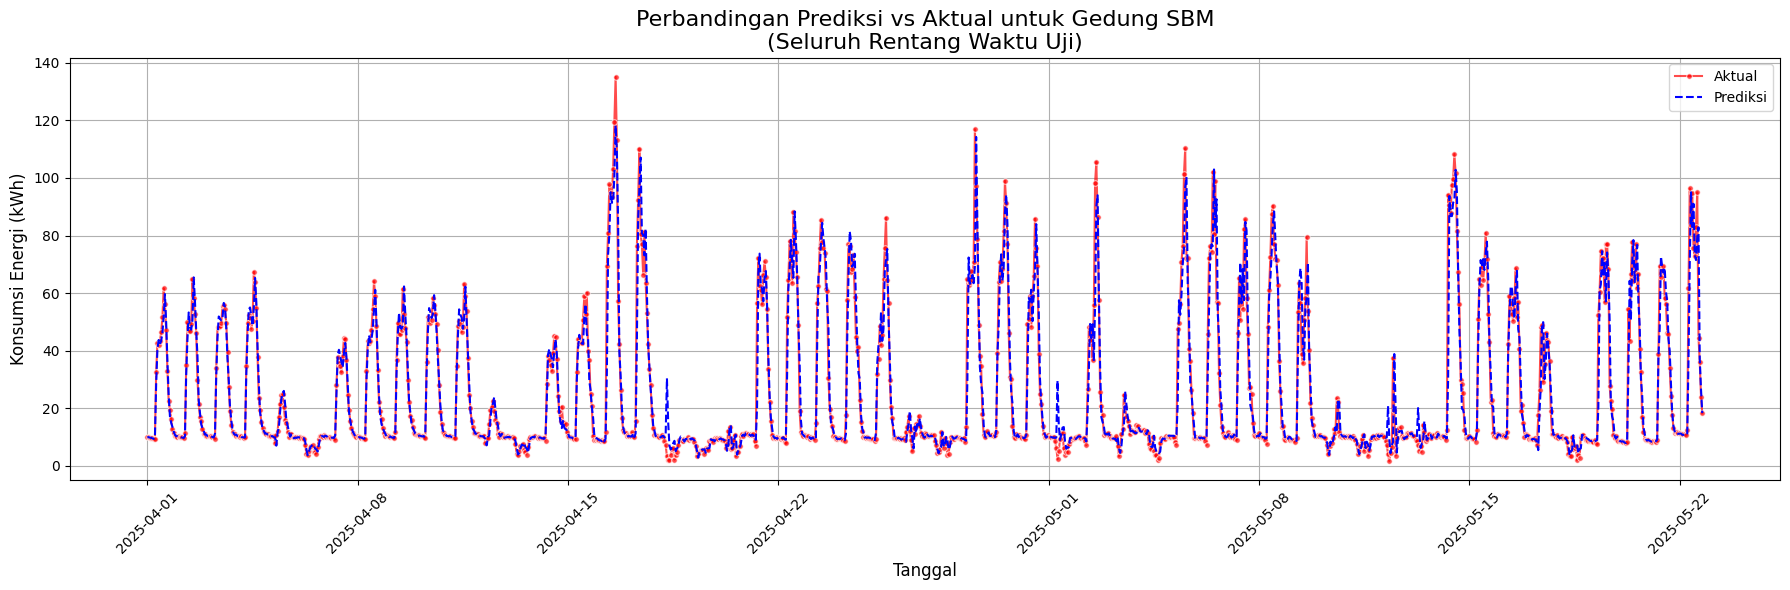

<Figure size 1200x800 with 0 Axes>

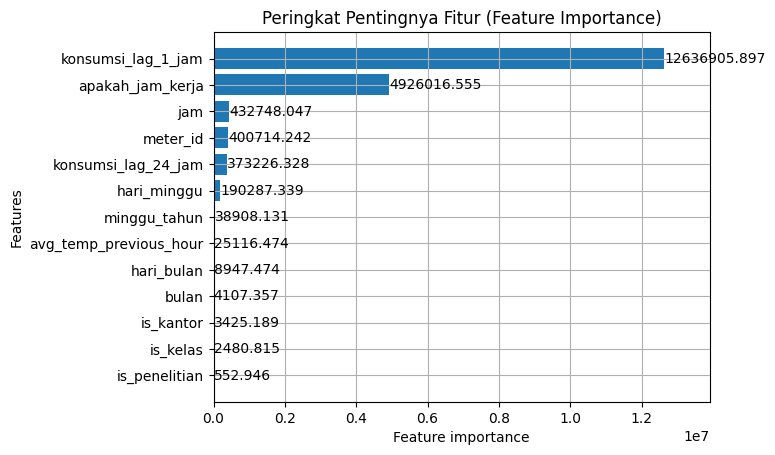

In [43]:
# --- 5. Visualisasi Hasil ---

from mydef import plot_prediksi_vs_aktual
# --- Menggunakan Fungsi Visualisasi ---
# 1. Siapkan DataFrame hasil
results = X_test.copy()
results['target_aktual'] = y_test
results['prediksi'] = predictions
results['timestamp'] = pd.to_datetime(test_set['timestamp'])

# 2. Panggil fungsi untuk melihat hasil (Anda bisa mengubah parameter ini)
# CONTOH 1: Melihat satu gedung spesifik untuk 7 hari
plot_prediksi_vs_aktual(results, meter_id_to_plot='SBM', start_date_str='all', end_date_str='all')
# plot_prediksi_vs_aktual(results, meter_id_to_plot='SBM', start_date_str='2025-04-01', end_date_str='2025-04-08')

# CONTOH 2: Melihat satu gedung spesifik untuk SELURUH rentang waktu uji
# plot_prediksi_vs_aktual(results, meter_id_to_plot='CAS', start_date_str='all', end_date_str='all')

# CONTOH 3: Melihat SEMUA gedung untuk 3 hari pertama (akan menghasilkan banyak plot)
# plot_prediksi_vs_aktual(results, meter_id_to_plot='all', start_date_str='2025-04-01', end_date_str='2025-04-03')


# 3. Plot Pentingnya Fitur (tetap sama)
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.8)
plt.title('Peringkat Pentingnya Fitur (Feature Importance)')
plt.show()

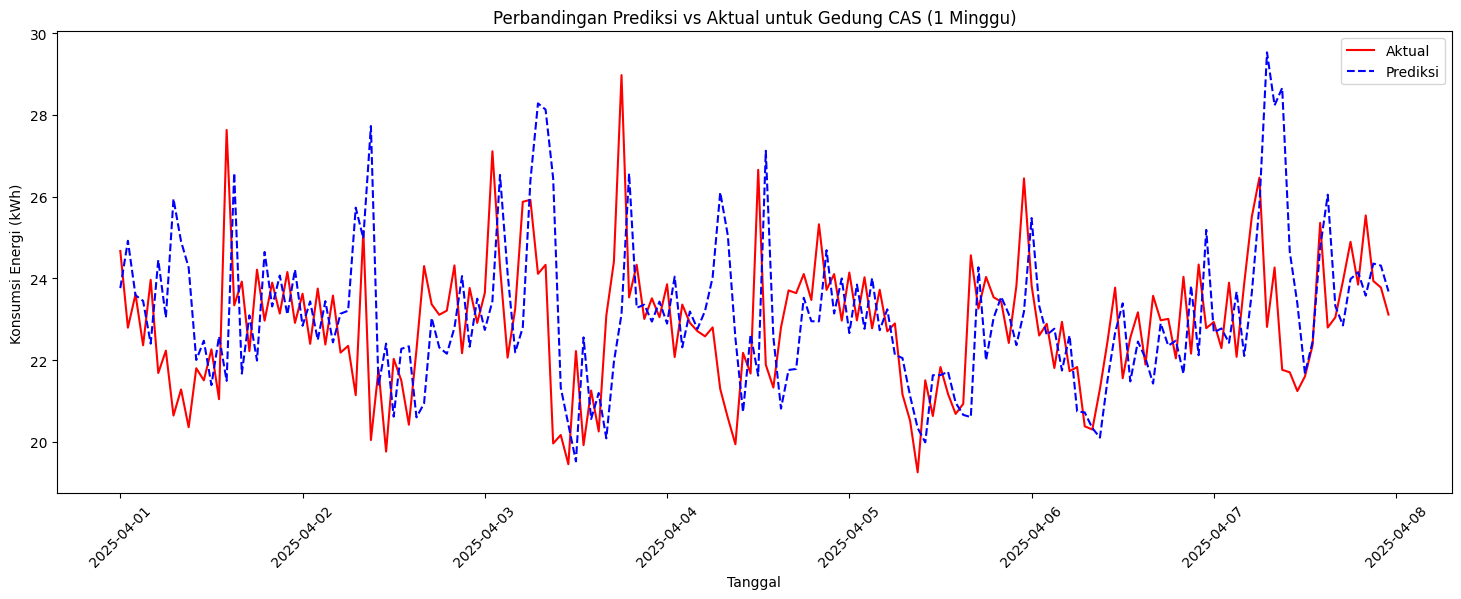

<Figure size 1200x800 with 0 Axes>

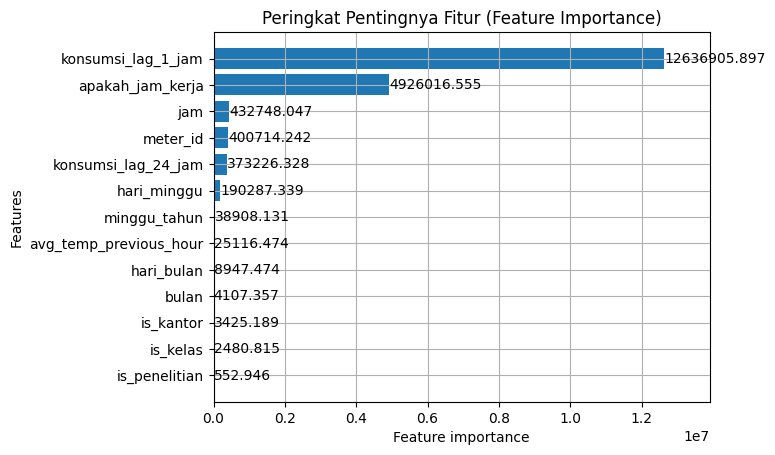

In [7]:
# 1. Plot Perbandingan Prediksi vs Aktual
# Kita ambil sampel dari data uji untuk visualisasi (misal: satu minggu pertama)
results = X_test.copy()
results['target_aktual'] = y_test
results['prediksi'] = predictions
results['timestamp'] = pd.to_datetime(test_set['timestamp']) # Tambahkan kembali timestamp untuk plot

# Plot untuk satu gedung saja agar jelas, contoh: 'CAS'
plt.figure(figsize=(18, 6))
sns.lineplot(data=results[results['meter_id']=='CAS'].iloc[:168], x='timestamp', y='target_aktual', label='Aktual', color='red')
sns.lineplot(data=results[results['meter_id']=='CAS'].iloc[:168], x='timestamp', y='prediksi', label='Prediksi', color='blue', linestyle='--')
plt.title('Perbandingan Prediksi vs Aktual untuk Gedung CAS (1 Minggu)')
plt.xlabel('Tanggal')
plt.ylabel('Konsumsi Energi (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.show()


# 2. Plot Pentingnya Fitur (Feature Importance)
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.8)
plt.title('Peringkat Pentingnya Fitur (Feature Importance)')
plt.show()
